## Apply all imports here

In [1]:
from os import listdir, getcwd
import os
from os.path import isfile, join
import subprocess
import sys
import csv
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt



## Read all csv files 

In [3]:
mypath = join(getcwd(), 'eval_results/soot_res')
# print(mypath)

csv_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(csv_files)

csv_files = ['soot_ide_eval_vm_cha_1.csv']

completepaths = [os.path.join(mypath, f) for f in csv_files]
# print(completepaths)

# desired_col = ["jar","solver","thread","totalRuntime","cgConstructionTime","prop","method","mem","CallGraphAlgo","callGraphEdges","callGraphReachableNodes","initialStmtCount","stmtCountAfterApplyingBI","BodyTransformers","BodyTransformersMetrics"]
desired_col = ["jar","solver","thread","totalRuntime","cgConstructionTime","prop","method","mem","CallGraphAlgo","callGraphEdges","callGraphReachableNodes","initialStmtCount","stmtCountAfterApplyingBI","BodyTransformers","BodyTransformersMetrics"]

for completefilepath in completepaths:
    # print(completefilepath)
    csv_cols = next(csv.reader(open(completefilepath))) # read only the csv columns names

    cols = [col for col in desired_col if col in csv_cols]
    df = pd.read_csv(completefilepath, sep=";", header=0)
    print(df.head())
    print("-----------")

df.iloc[0]

['soot_ide_eval_CHA_20_run1.csv', 'soot_ide_eval_CHA_20_run2_hp.csv', 'soot_ide_eval_mix_run3_hp.csv', 'soot_ide_eval_RTA_17_run1.csv', 'soot_ide_eval_RTA_17_run2.csv', 'soot_ide_eval_vm_cha_1.csv']
                   jar   solver  thread  totalRuntime  cgConstructionTime  \
0  jackson-core-2.14.2  default       1          6966                1347   
1  jackson-core-2.14.2  default       1          6988                1372   
2  jackson-core-2.14.2  default       1          6957                1313   
3  jackson-core-2.14.2  default       1          6994                1364   
4  jackson-core-2.14.2  default       1          7000                1350   

     prop  method  mem CallGraphAlgo  callGraphEdges  callGraphReachableNodes  \
0  812982      50  713           CHA           16804                     3701   
1  812982      50  388           CHA           16804                     3701   
2  812982      50  727           CHA           16804                     3701   
3  812982     

jar                                                       jackson-core-2.14.2
solver                                                                default
thread                                                                      1
totalRuntime                                                             6966
cgConstructionTime                                                       1347
prop                                                                   812982
method                                                                     50
mem                                                                       713
CallGraphAlgo                                                             CHA
callGraphEdges                                                          16804
callGraphReachableNodes                                                  3701
initialStmtCount                                                        63301
stmtCountAfterApplyingBI                                        

In [5]:
df.groupby('jar')['jar'].count()

jar
commons-codec-1.15            720
commons-io-2.11.0             720
commons-lang3-3.12.0          720
commons-logging-1.2           720
gson-2.10.1                   720
jackson-annotations-2.14.2    720
jackson-core-2.14.2           730
jakarta.servlet-api-6.0.0     720
jcl-over-slf4j-2.0.7          720
joda-time-2.12.5              720
jsr305-3.0.2                  720
junit-jupiter-api-5.9.2       720
junit-jupiter-engine-5.9.2    720
slf4j-api-2.0.7               720
slf4j-reload4j-2.0.7          720
slf4j-simple-2.0.7            720
testng-7.7.1                  667
Name: jar, dtype: int64

## Convert csv with , files

In [2]:
import re
import json
import pandas as pd
import csv
import ast

mypath = join(getcwd(), 'eval_results/soot_res')
# print(mypath)

csv_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# print(csv_files)
# csv_files = ['soot_ide_eval_CHA_20_run1.csv','soot_ide_eval_CHA_20_run2_hp.csv', 'soot_ide_eval_RTA_17_run1.csv', 'soot_ide_eval_RTA_17_run2.csv']
csv_files = ['soot_ide_eval_CHA_20_run1.csv','soot_ide_eval_CHA_20_run2_hp.csv']

completepaths = [os.path.join(mypath, f) for f in csv_files]
# print(completepaths)

for completepath in completepaths:
    with open(completepath, 'r', encoding='UTF-8') as file:
        lines = [line.rstrip() for line in file]

print(lines[1])

# input_str = """
# jar,solver,thread,totalRuntime,cgConstructionTime,prop,method,mem,CallGraphAlgo,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,BodyTransformers,BodyTransformersMetrics
# assertj-core-3.24.2,default,1,88422,5368,3974427,50,554,CHA,57910,13599,101912,102790,[JB_LS, JB_TR],{jb.tr=[1470, -366], jb.ls=[903, -50]}
# assertj-core-3.24.2,default,1,62110,6085,3020975,50,594,CHA,57910,13599,101912,102790,[JB_LS, JB_TR, JB_LP],{jb.tr=[1424, 2], jb.lp=[697, -126], jb.ls=[731, -476]}
# """
input_str = '\n'.join(lines)
# print(input_str)

new_ouput = ""
new_different_output = ""
for each_row in input_str.split('\n'): 
    # print(each_row)
    if each_row.strip() != "":
        split_row = each_row.split(',')
        new_ouput += ','.join(split_row[:13])
        new_ouput += '\n'
        new_different_output += ','.join(split_row[13:])
        new_different_output += '\n'

# with open('simple_output.csv', 'w') as file:
#     file.write(new_ouput)

# df = pd.read_csv('simple_output.csv')
# # print(df.head())

TESTDATA = StringIO(new_ouput)
df = pd.read_csv(TESTDATA, sep=",")

pattern = r'^(\[.*?\]),(\{.*\})$'

each_index = 0
for each_row in new_different_output.split('\n'):
    if each_row.strip() != "" and not each_row.startswith('BodyTransformers'):
        match = re.match(pattern, each_row)
        if match:
            BodyTransformers_str = match.group(1)
            column_y = BodyTransformers_str.strip('[]').split(',')
            # print(each_index)
            df.loc[each_index, 'BodyTransformers'] = json.dumps(column_y)
            column_z_str = match.group(2).replace('=', ':')
            # column_z_str = re.sub(r'([\w\.]+):', r'"\1":', column_z_str)
            column_z_str = re.sub(r'([a-zA-Z0-9._-]+):', r'"\1":', column_z_str)
            # string_literal = repr(column_z_str)
            # print(column_z_str)
            column_z = json.loads(column_z_str)
            df.loc[each_index, 'BodyTransformersMetrics'] = json.dumps(column_z)
        each_index += 1

# print(df.head())

df_CHA = df[df['CallGraphAlgo'] == 'CHA']
df_RTA = df[df['CallGraphAlgo'] == 'RTA']
print(f"df CHA rows: {len(df_CHA.index)} columns: {len(df_CHA.columns)}")
print(f"df RTA rows: {len(df_RTA.index)} columns: {len(df_RTA.columns)}")

assertj-core-3.24.2,default,1,157630,11489,3946320,50,473,CHA,57918,13601,101910,102790,[JB_LS, JB_TR],{jb.tr=[3019, -223], jb.ls=[1855, -48]}
df CHA rows: 961 columns: 15
df RTA rows: 0 columns: 15


In [ ]:
for key, value in df_CHA['BodyTransformersMetrics'].items():
    None
    # print(value)

df_CHA.head(1)
df_CHA.describe

## BodyTransfomers Combination VS totaltime for LCP (CHA)

In [ ]:
import pandas as pd

# Sample data
data = {
    'totalRuntime': df_CHA['totalRuntime'].values.tolist(),
    'BodyTransformers':  df_CHA['BodyTransformers'].values.tolist()
}

# Create a DataFrame
df_bi_lcp = pd.DataFrame(data)

# Explode the BodyTransformers list to create one row per transformer
df_exploded_bi_lcp = df_bi_lcp.explode('BodyTransformers')
print(df_exploded_bi_lcp)

# Group by BodyTransformer and calculate the mean totalRuntime for each transformer
transformer_runtime = df_exploded_bi_lcp.groupby('BodyTransformers')['totalRuntime'].mean()

# Display the result
print(transformer_runtime)

# Plot the results
plt.figure(figsize=(20, 10))
transformer_runtime.plot(kind='bar', color='skyblue')

plt.xticks(ticks=range(len(transformer_runtime)), labels=transformer_runtime.index, rotation=90)
plt.title('Average Total Runtime for Each BodyTransformer')
plt.xlabel('BodyTransformer')
plt.ylabel('Average Total Runtime')
plt.tight_layout()

# Show the plot
plt.show()


## BodyTransfomers Combination VS Stmt Count (CHA)

In [ ]:
df_CHA.head()
df1 = df_CHA[['initialStmtCount', 'stmtCountAfterApplyingBI', 'BodyTransformers']]
df1.iloc[90:120]
print('\n'.join(lines[:15]))

In [ ]:
df_CHA['stmtChange'] = df_CHA['initialStmtCount'] - df_CHA['stmtCountAfterApplyingBI']
df_CHA['stmtChange'] = df_CHA['stmtChange'].abs()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'stmtChange': df_CHA['stmtChange'].values.tolist(),
    'BodyTransformers':  df_CHA['BodyTransformers'].values.tolist()
}

# Create a DataFrame
df_bi_stmts = pd.DataFrame(data)

# Explode the BodyTransformers list to create one row per transformer
df_exploded_bi_stmts = df_bi_stmts.explode('BodyTransformers')
print(df_exploded_bi_stmts)

# Group by BodyTransformer and calculate the mean totalRuntime for each transformer
transformer_stmtChange = df_exploded_bi_stmts.groupby('BodyTransformers')['stmtChange'].mean()

# Display the result
print(transformer_stmtChange)

# Plot the results
plt.figure(figsize=(20, 10))
transformer_stmtChange.plot(kind='bar', color='skyblue')

plt.xticks(ticks=range(len(transformer_stmtChange)), labels=transformer_runtime.index, rotation=90)
plt.title('Average Statement Change for Each BodyTransformer')
plt.xlabel('BodyTransformer')
plt.ylabel('Average Statement Change')
plt.tight_layout()

# Show the plot
plt.show()


## Relationship between `Each BodyTransformer` and the `totalRuntime` using Correlation

In [6]:
# Import necessary libraries
import pandas as pd
import ast
 
# Sample data as provided
data = {
    'totalRuntime': df['totalRuntime'].values.tolist(),
    'BodyTransformersMetrics': df['BodyTransformersMetrics'].values.tolist()
}
 
# Create dataframe
df_1 = pd.DataFrame(data)
 
# Function to convert BodyTransformersMetrics string to a dictionary
def parse_body_transformers_metrics(metrics_str):
    return ast.literal_eval(metrics_str)
 
# Apply the function to parse the BodyTransformersMetrics column
df_1['BodyTransformersMetrics'] = df_1['BodyTransformersMetrics'].apply(parse_body_transformers_metrics)
 
# Extract individual BodyTransformers and their corresponding time taken
for index, row in df_1.iterrows():
    for transformer, metrics in row['BodyTransformersMetrics'].items():
        # Create a new column for each transformer and fill it with the time taken (first element of the list)
        df_1.at[index, transformer] = metrics[0]
 
# Drop the original 'BodyTransformersMetrics' column since it's no longer needed
df_1.drop(columns=['BodyTransformersMetrics'], inplace=True)
 
# Now let's analyze the relationship between each BodyTransformer and the totalRuntime
# Calculate the correlation matrix to find relationships between the columns
correlation_matrix = df_1.corr()
 
# Display the correlation matrix
correlation_matrix

,totalRuntime,jb.tr,jb.ls,jb.lp,jb.ese,jb.ne,jb.dae,jb.ule,jb.cp,jb.uce,jb.tt,jb.lns,jb.cbf,jb.dtr,jb.sils,jb.a,jb.ulp,jb.cp-ule
totalRuntime,1.000000,0.889877,0.863742,0.935439,0.895910,0.855858,0.958077,0.862117,0.933798,0.835201,0.917655,0.865239,0.879155,0.930109,0.967457,0.963944,0.932531,0.499258
jb.tr,0.889877,1.000000,0.979806,0.988822,0.906216,0.944131,0.990723,0.929102,0.996991,0.885695,0.958729,0.960542,0.948717,0.901748,0.987161,0.977293,0.982517,0.658513
jb.ls,0.863742,0.979806,1.000000,0.984793,0.928181,0.943335,0.982821,0.876573,0.991922,0.845287,0.968565,0.978366,0.954938,0.897047,0.987068,0.983104,0.991677,0.640039
jb.lp,0.935439,0.988822,0.984793,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.ese,0.895910,0.906216,0.928181,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.ne,0.855858,0.944131,0.943335,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.dae,0.958077,0.990723,0.982821,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.ule,0.862117,0.929102,0.876573,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.cp,0.933798,0.996991,0.991922,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jb.uce,0.835201,0.885695,0.845287,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_1.head

<bound method NDFrame.head of      totalRuntime   jb.tr   jb.ls   jb.lp  jb.ese  jb.ne  jb.dae  jb.ule  \
0          157630  3019.0  1855.0     NaN     NaN    NaN     NaN     NaN   
1           96568  2878.0  1520.0  1443.0     NaN    NaN     NaN     NaN   
2          138687  2947.0  1641.0     NaN    94.0    NaN     NaN     NaN   
3          137373  3880.0  2046.0     NaN     NaN  103.0     NaN     NaN   
4          131336  3015.0  1596.0     NaN     NaN    NaN  1080.0     NaN   
..            ...     ...     ...     ...     ...    ...     ...     ...   
956        139934  2128.0  1167.0     NaN     NaN    NaN     NaN     NaN   
957        132484  1949.0   836.0     NaN     NaN    NaN     NaN     NaN   
958        142220  2251.0   969.0     NaN     NaN    NaN     NaN     NaN   
959        124781  2109.0   944.0     NaN     NaN    NaN     NaN     NaN   
960        123916  1948.0  1102.0     NaN     NaN    NaN     NaN     NaN   

     jb.cp  jb.uce  jb.tt  jb.lns  jb.cbf  jb.dtr  jb.sil

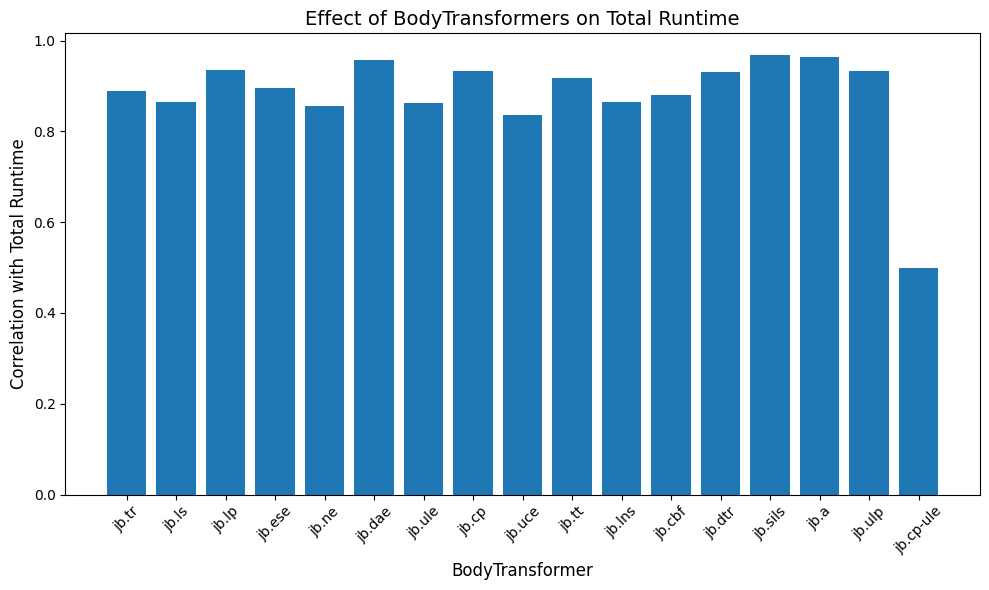

In [10]:
'''
To visualize the impact of each BodyTransformer on the total runtime, we can compute a metric that captures the effect of each BodyTransformer 
on the total time taken. For this analysis, we can use the correlation values between each BodyTransformer's time and the total runtime as a 
measure of effect. We will then create a bar plot with the BodyTransformers on the x-axis and their corresponding effect on the y-axis.
'''

'''- **Y-axis**: Correlation between each BodyTransformer's time and the `totalRuntime`. The correlation is a metric that indicates how much the time spent on a specific BodyTransformer is related to the total runtime.
  - Positive correlation means that as the time taken by a BodyTransformer increases, the total runtime tends to increase.
  - Negative correlation suggests the opposite.
 
This graph will help visualize which BodyTransformer has the most significant effect (either positively or negatively) on the total runtime.'''


# We already have the correlation matrix from previous steps
# Extract the correlation values between totalRuntime and each BodyTransformer
correlation_with_runtime = correlation_matrix['totalRuntime'].drop('totalRuntime')
 
# Plot the effect of each BodyTransformer on the totalRuntime
plt.figure(figsize=(10, 6))
plt.bar(correlation_with_runtime.index, correlation_with_runtime.values)
plt.title('Effect of BodyTransformers on Total Runtime', fontsize=14)
plt.xlabel('BodyTransformer', fontsize=12)
plt.ylabel('Correlation with Total Runtime', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
 
# Show the plot
plt.show()


## Relationship between Each BodyTransformer and the totalRuntime using ANOVA

In [11]:
'''We will use **ANOVA** (since you have more than two BodyTransformers) to check if some of the BodyTransformers are making the total 
runtime significantly different.'''

'''### Explanation of the ANOVA Code:
1. We look at all the **BodyTransformers** (e.g., `jb.tr`, `jb.ls`) and grab the time taken for each.
2. We run an **ANOVA test** to check if there’s any significant difference between the transformers.
3. The output gives us an **F-statistic** and a **p-value**.
   - **F-statistic**: Tells us how big the difference is.
   - **p-value**: If this is less than 0.05, we say, "Yes! Some transformers really affect the total time!"
 
### What's Next:
- If the **p-value** is less than 0.05, we can conclude that **some BodyTransformers significantly affect the total runtime** more than others.
- If it's greater than 0.05, we would say the BodyTransformers are **not significantly different** from each other.'''

from scipy import stats
 
# Prepare the data for ANOVA test
# Extracting times for each BodyTransformer (e.g., jb.tr, jb.ls, etc.)
transformers = [col for col in df_1.columns if col != 'totalRuntime']
 
# Perform one-way ANOVA test
anova_result = stats.f_oneway(*[df_1[transformer].dropna() for transformer in transformers])
 
# Display the result
anova_result

# F_onewayResult(statistic=np.float64(14.524264603558748), pvalue=np.float64(1.1636712085756704e-38))

F_onewayResult(statistic=np.float64(14.524264603558748), pvalue=np.float64(1.1636712085756704e-38))

## Relationship between Each BodyTransformer and the totalRuntime using Regression analysis

In [5]:
'''
Regression analysis will help us understand how much each `BodyTransformer` affects the total runtime. Specifically, we'll perform a 
**multiple linear regression**, where the `totalRuntime` will be our dependent variable, and the times taken by each `BodyTransformer` 
will be the independent variables.

### Explanation of the Code:
 
1. **Independent Variables (X)**: These are the columns that represent the time taken by each `BodyTransformer`. We drop the `totalRuntime` column since it’s the dependent variable.
2. **Dependent Variable (y)**: This is the `totalRuntime` column, which we are trying to predict based on the time taken by each `BodyTransformer`.
3. **Add Constant**: This step adds an intercept (a baseline value) to the model.
4. **OLS (Ordinary Least Squares) Model**: We fit a linear regression model using the independent variables to predict `totalRuntime`.
5. **Model Summary**: The `summary()` function provides key outputs such as:
   - **Coefficients**: These tell us how much each `BodyTransformer` affects the total runtime.
   - **p-values**: If the p-value for a `BodyTransformer` is less than 0.05, it means that the time taken by that `BodyTransformer` significantly affects the total runtime.
   - **R-squared**: This tells us how well the independent variables explain the variation in `totalRuntime`. The closer this value is to 1, the better the model.
 
### Understanding the Results:
 
- **Coefficients**: These show how much the `totalRuntime` will change when the time for a specific `BodyTransformer` increases by one unit. A positive value means an increase in time increases the `totalRuntime`, while a negative value means it decreases the `totalRuntime`.
- **p-value**: If the p-value is small (typically less than 0.05), it means that the corresponding `BodyTransformer` has a significant effect on the total runtime.
- **R-squared**: This tells us how much of the variation in `totalRuntime` is explained by the time taken by the BodyTransformers. The closer this value is to 1, the better the fit.
 
### Next Steps:
Once you run this code, you’ll get insights into:
- Which BodyTransformers significantly affect the total runtime.
- How much each BodyTransformer impacts the total runtime.
'''
import pandas as pd
import statsmodels.api as sm
 
# Assuming df is already created as per the previous steps and each BodyTransformer has its column with time
# We will use the time for each transformer to predict totalRuntime
 
# Extract independent variables (BodyTransformers) and dependent variable (totalRuntime)
df_new = df_1.copy()
df_new.head()

X = df_new['BodyTransformersMetrics']
y = df_new['totalRuntime']
 
# Add a constant to the model (for the intercept)
X = sm.add_constant(X)
 
# Fit the regression model
model = sm.OLS(y, X).fit()
 
# Print out the regression results
print(model.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).